# Tanzania Water Well Classification

## Table of Contents

> #### 1. [Business Understanding](#Business-Understanding)
> #### 2. [Data Understanding](#Data-Understanding)
> #### 3. [Data Preparation](#Data-Preparation)
> #### 4. [Modeling](#Modeling)
> #### 5. [Evaluation](#Evaluation)
> #### 6. [Conclusions](#Conclusions)
> #### 7. [Resources](#Resources)

## 1. <a name ="Business-Understanding"></a> Business Understanding

### Background 

The country of Tanzania is struggling to provide safe, clean water to its more than 67 million citizens. A non-governmental organization (NGO) is assisting the Tanzanian government in addressing this critical issue by repairing damaged water wells. With over 70k water wells scattered across an area larger than twice the size of California, testing every single well is both costly and time-consuming.

Water from these wells is not only vital for drinking but also essential for cooking, sanitation, and hygiene practices. Ensuring access to clean water significantly impacts the health and livelihoods of the community. Therefore, the NGO requires an efficient method to identify which water wells need repair, streamlining their efforts to provide safe, clean water for all Tanzanians.

### Business Goals

The primary focus of this machine learning project is to assist the NGO in identifying all water wells requiring repair, enabling timely interventions to ensure safe, clean water for Tanzanians. The project aims to accurately identify every positive case (water well in need of repair) while minimizing false negatives, which occur when a well is incorrectly classified as functioning properly when, in reality, it is in need of repair.

Although some functional wells may be incorrectly classified as needing repair, the prevention of potential health hazards is of utmost importance. Therefore, the model prioritizes identifying wells that need repair, erring on the side of caution to ensure the safety of citizens who rely on these essential water sources.

### Business Success Criteria

The success of this project will be measured primarily by the model’s ability to classify wells in need of repair. The key metric associated with this ability is called recall, which addresses the question: 

> _“Out of all the wells that actually need repair, what percentage did our model correctly identify as needing repair?”_ 

Recall is calculated by dividing the number of true positives (the number of wells that genuinely require repair) by the combined total of true positives and false negatives (the wells that require repair but were incorrectly labeled as functional). 

$$
\text{Recall} = \frac {\text{True  Positives}}{\text{True  Positives + False  Negatives}}
$$

## 2. <a name ="Data-Understanding"></a> Data Understanding

This data was collected by Taarifa and the Tanzanian Ministry of Water. The dataset includes 41 features and 59400 entries. 

Each entry in the dataset represents a water well in Tanzania, where `id` is its unique identifier. Additional information is included about each well such as the `latitude` and `longitude`, along with its water source --`source_type`-- and its total static head --`amount_tsh`-- (in other words the amount of water available to waterpoint). 

The target in this classification problem is stored in the column labeled `status_group`. Prior to any cleaning and preprocessing, this column includes three classes: functional, functional needs repair, and non-functional.

More information about the data can be found [here]( https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/data/).

Steps of Data understanding
- 2.1 import packages
- 2.2 read in data
- 2.3 get a preview of the data
    - 3a `.head()`
    - 3b `.info()`
 
- 2.4 Get summary statistics for the data
- 2.5 Visualize the data
- 2.6 Investigate the number of null values 
    - 2.6.1 `.isna()`
    
- 2.7 Investigate contents within each feature
    - 2.7.1 `.value_counts()`
    - 2.7.2 `.nunique()`
- 2.8 Investigate specific entries 

In [1]:
# importing necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

# for GIS/mapping
import pandas as pd
import matplotlib.pyplot as plt
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon

# for splitting into training, test, and validation sets
from sklearn.model_selection import train_test_split, cross_val_score

# feature selection
from sklearn.feature_selection import RFE

# classification models
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import tree

# preprocessing 
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

# metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.metrics import classification_report

In [2]:
# reading csv files for training data and labels

target = pd.read_csv('./data/training_set_labels.csv')
features = pd.read_csv('./data/training_set_values.csv')

In [3]:
features.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [4]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

In [5]:
target.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


In [6]:
target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            59400 non-null  int64 
 1   status_group  59400 non-null  object
dtypes: int64(1), object(1)
memory usage: 928.2+ KB


In [7]:
data = features.merge(target, how = 'inner', on = 'id')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

In [8]:
data.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


In [9]:
data.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


This output shows the summary statistics for the numeric columns. From this output, we can see that gps_height and population appear to be right skewed due to the fact that the mean is significantly larger than the median. This indicates the probable presence of outliers. 

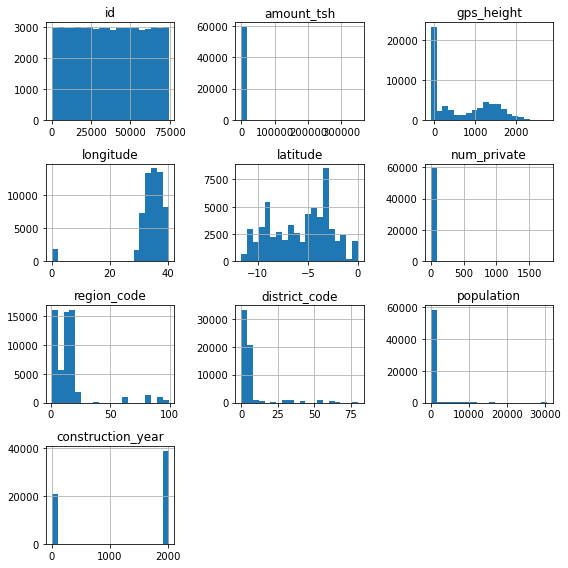

In [10]:
data.hist(bins = 20, figsize = (8,8))
plt.tight_layout();

In [11]:
# getting the percentage of null values in each feature

round((data.isna().sum()*100)/len(data), 2)

id                        0.00
amount_tsh                0.00
date_recorded             0.00
funder                    6.12
gps_height                0.00
installer                 6.15
longitude                 0.00
latitude                  0.00
wpt_name                  0.00
num_private               0.00
basin                     0.00
subvillage                0.62
region                    0.00
region_code               0.00
district_code             0.00
lga                       0.00
ward                      0.00
population                0.00
public_meeting            5.61
recorded_by               0.00
scheme_management         6.53
scheme_name              47.42
permit                    5.14
construction_year         0.00
extraction_type           0.00
extraction_type_group     0.00
extraction_type_class     0.00
management                0.00
management_group          0.00
payment                   0.00
payment_type              0.00
water_quality             0.00
quality_

This outputs the percentage of data within each feature that is null values. From this, we see that funder, installer, subvillage, public_meeting, scheme_management, permit all have only a small percentage of missing values. scheme_name at almost 50% is the only feature with a percentage of null values above 10%. This feature will be a focus during the data preprocessing phase.  

In [12]:
data.nunique()

id                       59400
amount_tsh                  98
date_recorded              356
funder                    1897
gps_height                2428
installer                 2145
longitude                57516
latitude                 57517
wpt_name                 37400
num_private                 65
basin                        9
subvillage               19287
region                      21
region_code                 27
district_code               20
lga                        125
ward                      2092
population                1049
public_meeting               2
recorded_by                  1
scheme_management           12
scheme_name               2696
permit                       2
construction_year           55
extraction_type             18
extraction_type_group       13
extraction_type_class        7
management                  12
management_group             5
payment                      7
payment_type                 7
water_quality                8
quality_

In [13]:
# defining a function to assist with cardinality assessment of each feature
# this function prints the value counts for each feature in the given dataset

def multiple_value_counts(dataframe,list_of_columns):
    for col in list_of_columns:
        print("----" + col + "----")
        print()
        print(dataframe[col].value_counts())
        print()

In [14]:
multiple_value_counts(data, data.columns)

----id----

2047     1
72310    1
49805    1
51852    1
62091    1
        ..
46396    1
36155    1
34106    1
38200    1
0        1
Name: id, Length: 59400, dtype: int64

----amount_tsh----

0.0         41639
500.0        3102
50.0         2472
1000.0       1488
20.0         1463
            ...  
8500.0          1
6300.0          1
220.0           1
138000.0        1
12.0            1
Name: amount_tsh, Length: 98, dtype: int64

----date_recorded----

2011-03-15    572
2011-03-17    558
2013-02-03    546
2011-03-14    520
2011-03-16    513
             ... 
2011-09-06      1
2011-09-16      1
2011-09-27      1
2011-09-13      1
2011-09-17      1
Name: date_recorded, Length: 356, dtype: int64

----funder----

Government Of Tanzania    9084
Danida                    3114
Hesawa                    2202
Rwssp                     1374
World Bank                1349
                          ... 
Lake Tanganyika Prodap       1
Padep(mifugo)                1
Rotary                       1
Sh

never pay     25348
per bucket     8985
monthly        8300
unknown        8157
on failure     3914
annually       3642
other          1054
Name: payment_type, dtype: int64

----water_quality----

soft                  50818
salty                  4856
unknown                1876
milky                   804
coloured                490
salty abandoned         339
fluoride                200
fluoride abandoned       17
Name: water_quality, dtype: int64

----quality_group----

good        50818
salty        5195
unknown      1876
milky         804
colored       490
fluoride      217
Name: quality_group, dtype: int64

----quantity----

enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity, dtype: int64

----quantity_group----

enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity_group, dtype: int64

----source----

spring                  17021
shal

The above output gives the value counts and number of unique entries for each feature in the training data. This helps understand the cardinality of each feature. Features with high cardinality, such as wpt_name (37400 unique entries) and subvillage (19287 unique entries), may not be helpful in this classification. Thus, these features will be an area of focus during the data preparation phase. 

In [15]:
# displays values within the funder feature

data['funder'].str.lower().value_counts()

government of tanzania    9084
danida                    3114
hesawa                    2202
rwssp                     1374
world bank                1349
                          ... 
namungo miners               1
john fund                    1
mzee mkungata                1
drwssp                       1
dv                           1
Name: funder, Length: 1897, dtype: int64

In [16]:
#displays categories within installer feature

data['installer'].str.lower().value_counts()

dwe           17405
government     1891
hesawa         1395
rwe            1206
commu          1065
              ...  
priv              1
mbiusa            1
zinduka           1
waitaliano        1
dv                1
Name: installer, Length: 1935, dtype: int64

In [17]:
data[['installer', 'funder']].value_counts()

installer   funder                
DWE         Government Of Tanzania    4254
Government  Government Of Tanzania    1607
DWE         Hesawa                    1296
DANIDA      Danida                    1046
DWE         Rwssp                      914
                                      ... 
Machibya    Makoye Masanzu               1
            Machibya Guma                1
Ma          Matimbwa Sec                 1
            Majengo Prima                1
Kilol       Kilol                        1
Length: 3697, dtype: int64

In [18]:
data[['water_quality', 'quality_group']].value_counts()

water_quality       quality_group
soft                good             50818
salty               salty             4856
unknown             unknown           1876
milky               milky              804
coloured            colored            490
salty abandoned     salty              339
fluoride            fluoride           200
fluoride abandoned  fluoride            17
dtype: int64

In [19]:
#calculates the percentage of installers known as DWE

round(data['installer'].value_counts()['DWE']/ 
      data['installer'].count(), 2) * 100

31.0

In [20]:
round(data['construction_year'].value_counts()[0]/ 
      data['construction_year'].count(), 2) * 100

35.0

In [21]:
# examining the entries of wells with longitude = 0
data[data['longitude'] == 0]

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
21,6091,0.0,2013-02-10,Dwsp,0,DWE,0.0,-2.000000e-08,Muungano,0,...,unknown,unknown,unknown,unknown,shallow well,shallow well,groundwater,hand pump,hand pump,functional
53,32376,0.0,2011-08-01,Government Of Tanzania,0,Government,0.0,-2.000000e-08,Polisi,0,...,unknown,unknown,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
168,72678,0.0,2013-01-30,Wvt,0,WVT,0.0,-2.000000e-08,Wvt Tanzania,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
177,56725,0.0,2013-01-17,Netherlands,0,DWE,0.0,-2.000000e-08,Kikundi Cha Wakina Mama,0,...,soft,good,enough,enough,shallow well,shallow well,groundwater,other,other,non functional
253,13042,0.0,2012-10-29,Hesawa,0,DWE,0.0,-2.000000e-08,Kwakisusi,0,...,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,functional needs repair
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59189,62177,0.0,2011-07-18,Dwsp,0,DWE,0.0,-2.000000e-08,Wazazo,0,...,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional needs repair
59208,3631,0.0,2013-01-22,Dwsp,0,DWE,0.0,-2.000000e-08,Mtakuja,0,...,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional
59295,60843,0.0,2011-07-19,Rwssp,0,DWE,0.0,-2.000000e-08,Maendeleo,0,...,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional needs repair
59324,748,0.0,2013-01-22,World Vision,0,World Vision,0.0,-2.000000e-08,Mwazwilo,0,...,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional


In [22]:
# examining the latitudes of wells with longitude = 0
data[data['longitude'] == 0].latitude.value_counts()

-2.000000e-08    1812
Name: latitude, dtype: int64

In [23]:
# examining the amount_tsh of wells with longitude = 0
data[data['longitude'] == 0].amount_tsh.value_counts()

0.0    1812
Name: amount_tsh, dtype: int64

#### Class Distribution

In [24]:
# Gives the class distribution for the target
data.status_group.value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

The output above shows that the target has three classes. For practicality, I will turn this into a binary classification problem

In [25]:
# Gives the class distribution for the target as a percentage

round(data.status_group.value_counts(normalize = True), 2) * 100

functional                 54.0
non functional             38.0
functional needs repair     7.0
Name: status_group, dtype: float64

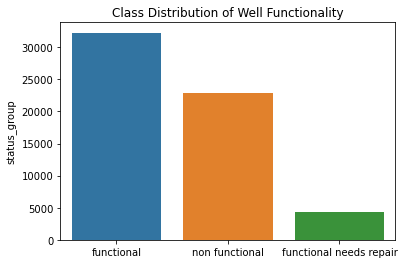

In [26]:
# Barplot of the class distribution
sns.barplot(x = data.status_group.value_counts().index,
            y = data.status_group.value_counts(), 
).set_title('Class Distribution of Well Functionality');

In [27]:
# reads in the Tanzania shape file
tanzania_map = gpd.read_file('./data/regions/Regions.shp')

# specifies the coordinate reference system
crs = {'init':'epsg:4326'}

#creates list of point objects consisting of latitudes and longitudes
geometry = [Point(xy) for xy in zip(data['longitude'], data['latitude'])]

# creates a dataframe from the training_data which includes the list of points
geo_df = gpd.GeoDataFrame(data,
                          crs = crs,
                          geometry = geometry
                         )

/Users/chriskucewicz/anaconda3/envs/learn-env/lib/python3.8/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


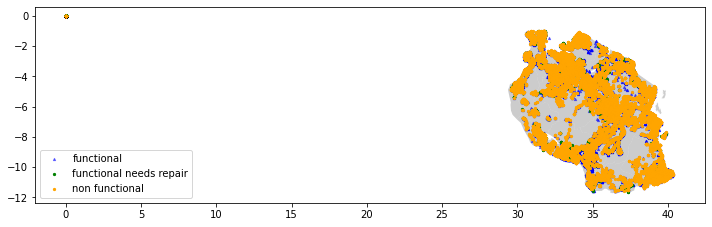

In [28]:
# plots map of Tanzania with points of wells overlaid

fig, ax = plt.subplots(figsize = (12, 12))
tanzania_map.plot(ax=ax, alpha=0.4, color='grey')

geo_df[geo_df['status_group'] == 'functional'].plot(ax=ax, 
                                      markersize=5, 
                                      color='blue', 
                                      marker='^', 
                                      label='functional',
                                      alpha = 0.5
                                                          )
geo_df[geo_df['status_group'] == 'functional needs repair'].plot(ax=ax, 
                                       markersize=5, 
                                       color='green', 
                                       marker='o', 
                                       label='functional needs repair'    
                                                     )

geo_df[geo_df['status_group'] == 'non functional'].plot(ax=ax, 
                                       markersize=5, 
                                       color='orange', 
                                       marker='o', 
                                       label='non functional'    
                                                     )


plt.legend();

The map shows the location of wells in Tanzania categorized by the status group - "functional" (blue), "functional needs repair" (green) or "non functional" (orange). From this map, it brings our attention to the points located in the northwest corner of the map. These points will be an area to address during the data preparation portion. It also shows us that the distribution of functional, functional needs repair, and non functional wells is evenly dispursed amongst the country with no real patterns emerging in any specific area for a well group. 

### Data Observations

Several features give the same info:
- scheme_name or scheme_management… probably 
- Extraction_type, extraction_type_group, extraction_type_class
- Management, management_group
- Payment, payment_type
- Water_quality, quality_group
- Quantity, quantity_group
- Source, source_type, source_class
- Waterpoint_type, waterpoint_type_group
- Geographic location:
 - Subvillage
 - Region
 - Region_code
 - District_code
 - Lga
 - ward


Other categories to consider dropping:
- scheme_name... 47% null values
- Num_private.. no description
- Public_meeting… what does this mean? 
- Wtp_name… is this important if we already have the id?
- Amount_tsh ...
- Date_recorded

Investigate further:
- Construction year entries with year 0… what’s going on there?? If we treat the 0s as nulls, that's 35% of our values as null. Rather than remove over 20k rows of data, it feels like it would be better to just remove the column itself. 
- longitude = 0 & latitude = -2.0e-8
- installer... clean and reduce cardinality

Action steps:
- change "status_group" name to "well_status"
- drop `recorded_by`. Only one value
- drop `payment`. Contains the same info as payment_type but payment_type is more descriptive
- drop `quantity_group`. Contains the same info as `quantity`
- drop waterpoint_type because it has same values as waterpoint_type_group but higher cardinality. Will be better for alogirhtm to deal with lower cardinality feature
- convert `permit` to boolean since it is already in T/F


## 3. <a name ="Data-Preparation"></a> Data Preparation

Based on my observations in the Data Understanding phase, I focus on the following during Data Preparation:
- 

Phases of Data Preparation:
  
  2. Drop `date_recorded`, `recorded_by`, `num_private`, `payment`, `quantity`, `scheme_name`, `wtp_name`, and `construction_year` columns
  3. Change status_group name to well_status
  4. Converge status_group to two classes
  4. Deal with `installer`
  1. Deal with duplicate columns (use decision tree or save for recursive feature elimination) 
      6. Management and management_group
      8. Extraction_type, extraction_type_group, extraction_type_class
      9. Payment, payment_type
      10. Water_quality, quality_group
      12. Source, source_type, source_class
      13. Waterpoint_type, waterpoint_type_group
      14. Locations: `subvillage`, `region`, `region_code`, `district_code`, `lga`, `ward`
  7. Handle remaining null values

In [29]:
#dropping columns
data.drop(columns = ['date_recorded', 'recorded_by', 'num_private', 'payment', 'quantity', 'scheme_name', 'wpt_name', 'construction_year'], axis = 1, inplace = True)

In [30]:
# renaming `status_group` to more descriptive title
data.rename(columns = {'status_group' : 'well_status'}, inplace = True)

In [31]:
# grouping classes into two groups for binary classification: Needs repair and Repair Not Needed
data.well_status.replace({'functional' : 'Repair Not Needed', 'non functional' : 'Needs Repair', 'functional needs repair' : 'Needs Repair'}, inplace = True)

In [32]:
# Gives the class distribution for the target
data.well_status.value_counts()

Repair Not Needed    32259
Needs Repair         27141
Name: well_status, dtype: int64

In [33]:
# Gives the class distribution for the target as a percentage

round(data.well_status.value_counts(normalize = True), 2) * 100

Repair Not Needed    54.0
Needs Repair         46.0
Name: well_status, dtype: float64

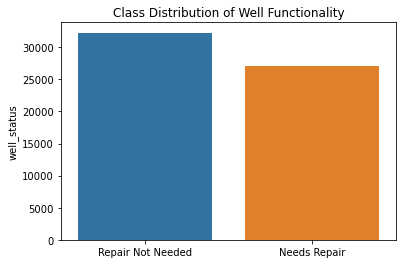

In [34]:
# Barplot of the class distribution
sns.barplot(x = data.well_status.value_counts().index,
            y = data.well_status.value_counts()
).set_title('Class Distribution of Well Functionality');

In [35]:
# cleaning installer feature
data['installer'] = data['installer'].str.lower()

In [36]:
data = data[data['installer'].notna()]

In [37]:
# creates a dictionary with categories and associated installer values
categories_dict = {
    'district_water_department': ['dwe', 'dw', 'district water department', 'rwe/dwe', 'district water depar', 'dwe}', 'dwe/', 'dwr', 'distri'],
    'government': ['government', 'central government', 'gover', 'gove', 'central govt', 'centr', 'tanzania government', 'govern', 'cipro/government', 'isf/government', 'rc church/central gover', 'canada na tanzania', 'concern /government', 'cental government', 'adra /government', 'cebtral government ', 'tanzania', 'governme', 'serikali', 'serikali ya kijiji'],
    'community': ['commu', 'community', 'adra/community', 'communit', 'village community', 'sekei village community', 'adra/ community', 'rwe /community', 'olgilai village comunity', 'killflora/ community', 'dads/village community', 'killflora /community', 'summit for water/community', 'rwe/community', 'rwe/ community', 'adra /community', 'twesa /community'],
    'finnish_government': ['fini water', 'finw', 'fw', 'finwater', 'fin water', 'finn water', 'finland government'],
    'catholic_church': ['rc church', 'rc', 'roman', 'rc ch', 'hw/rc', 'rcchurch/cefa', 'roman church', 'rc churc', 'rc c', 'roman catholic', 'roman catholic rulenge diocese', 'roman cathoric same', 'roman cathoric -kilomeni', 'rc/mission', 'kanisa katoliki'],
    'kkkt': ['kkkt', 'kkkt _ konde and dwe', 'kkkt church', 'kkt', 'kkkt-dioces ya pare', 'cct', 'kkt c'],
    'jica': ['jaica', 'jica', 'jika', 'ja', 'jeica', 'japan', 'gaica'],
    'unicef': ['unicef', 'unisef'],
    'local': ['local te', 'local  technician', 'local', 'local technician'],
    'unknown': ['not known', '0'],
    'danida': ['danida', 'danid', 'holland', 'belgiam government'],
    'tcrs': ['cipro/care/tcrs', 'tcrs'],
    'ministry_of_water': ['wizara ya maji', 'mwe', 'mwe &', 'ministry of water', 'ministry of water engineer', 'idara ya maji', 'idara', 'mamlaka ya maji ngara', 'mws'],
    'world_vision': ['world vision', 'world vission'],
    'norad': ['norad/', 'norad'],
    'tasaf': ['tasaf', 'tassaf', 'tasaf/dmdd', 'tasaf/'],
    'sema': ['water aid /sema', 'sema', 'water aid/sema', 'udc/sema', 'sema co ltd', 'water  aid/sema'],
    'oxfam': ['oxfam', 'oxfarm']
}

In [38]:
# loops through the dictionary to replace associated values

for category, values in categories_dict.items():
    data['installer'].replace(to_replace=values, value=category, inplace=True)

In [39]:
# creates a list of the top 25 installers
top25_installers = list(data['installer'].value_counts().index[:25])

In [40]:
# any installers not in the top25_installers gets grouped into 'other' category
data['installer'] = data['installer'].apply(lambda x: 'other' if x not in top25_installers else x)

In [41]:
data['installer'].value_counts()

district_water_department    18129
other                        16315
government                    3875
community                     1923
danida                        1713
hesawa                        1395
rwe                           1206
kkkt                          1202
finnish_government             972
district council               961
unknown                        822
tcrs                           713
world_vision                   711
catholic_church                664
ces                            610
ministry_of_water              571
tasaf                          497
jica                           448
amref                          443
lga                            413
wedeco                         398
dmdd                           376
norad                          366
sema                           360
unicef                         332
oxfam                          330
Name: installer, dtype: int64

In [42]:
#drops all rows where longitude = 0 and latitude = -2.0e-08
data.drop(data[(data['longitude'] == 0) & (data['latitude'] == -2.000000e-08)].index, inplace = True)

In [43]:
# check features remaining null totalas
round((data.isna().sum()*100)/len(data), 2)

id                       0.00
amount_tsh               0.00
funder                   0.10
gps_height               0.00
installer                0.00
longitude                0.00
latitude                 0.00
basin                    0.00
subvillage               0.69
region                   0.00
region_code              0.00
district_code            0.00
lga                      0.00
ward                     0.00
population               0.00
public_meeting           5.14
scheme_management        6.85
permit                   1.19
extraction_type          0.00
extraction_type_group    0.00
extraction_type_class    0.00
management               0.00
management_group         0.00
payment_type             0.00
water_quality            0.00
quality_group            0.00
quantity_group           0.00
source                   0.00
source_type              0.00
source_class             0.00
waterpoint_type          0.00
waterpoint_type_group    0.00
well_status              0.00
dtype: flo

In [44]:
data.dropna(inplace = True)

In [45]:
# changes columns with True/False values to boolean 1/0
data[['permit', 'public_meeting']] = data[['permit', 'public_meeting']].astype(int)

#### Decision Tree: `management` vs `management_group`

In [46]:
data[['management', 'management_group']].value_counts()

management        management_group
vwc               user-group          32940
wug               user-group           4187
water board       user-group           2664
wua               user-group           2287
private operator  commercial           1479
parastatal        parastatal           1267
water authority   commercial            788
company           commercial            654
other             other                 448
other - school    other                  99
trust             commercial             75
unknown           unknown                74
dtype: int64

In [60]:
data['management_group'].value_counts()

user-group    42078
commercial     2996
parastatal     1267
other           547
unknown          74
Name: management_group, dtype: int64

In [47]:
x = data[['management', 'management_group']]
y = data[['well_status']]

In [48]:
ohe = OneHotEncoder()

ohe.fit(x)
x_ohe = ohe.transform(x).toarray()

ohe_df = pd.DataFrame(x_ohe, columns=ohe.get_feature_names_out(x.columns))

ohe_df.head()

,management_company,management_other,management_other - school,management_parastatal,management_private operator,management_trust,management_unknown,management_vwc,management_water authority,management_water board,management_wua,management_wug,management_group_commercial,management_group_other,management_group_parastatal,management_group_unknown,management_group_user-group
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [49]:
mgmt_tree = DecisionTreeClassifier(criterion = 'entropy')
mgmt_tree.fit(x_ohe, y)

DecisionTreeClassifier(criterion='entropy')

In [52]:
feature_importances = mgmt_tree.feature_importances_

/Users/chriskucewicz/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


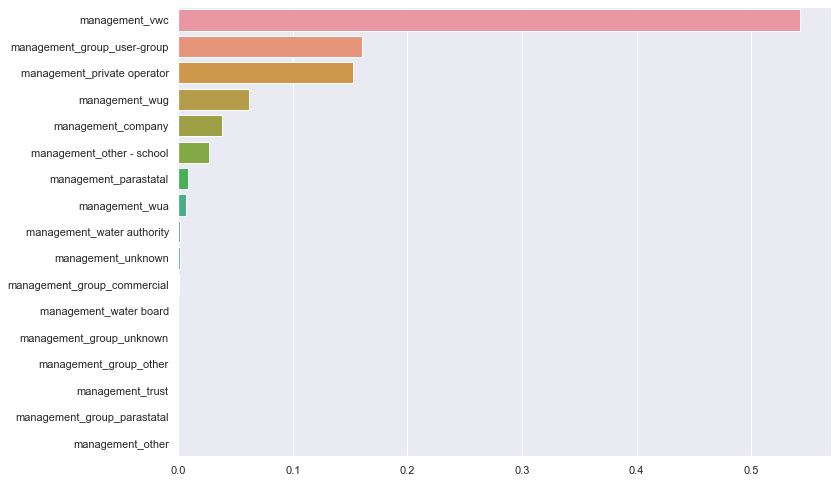

In [59]:
import seaborn as sns

# Sort the feature importances from greatest to least using the sorted indices
sorted_indices = feature_importances.argsort()[::-1]
sorted_feature_names = ohe_df.columns[sorted_indices]
sorted_importances = feature_importances[sorted_indices]

# Create a bar plot of the feature importances
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.barplot(sorted_importances, sorted_feature_names);

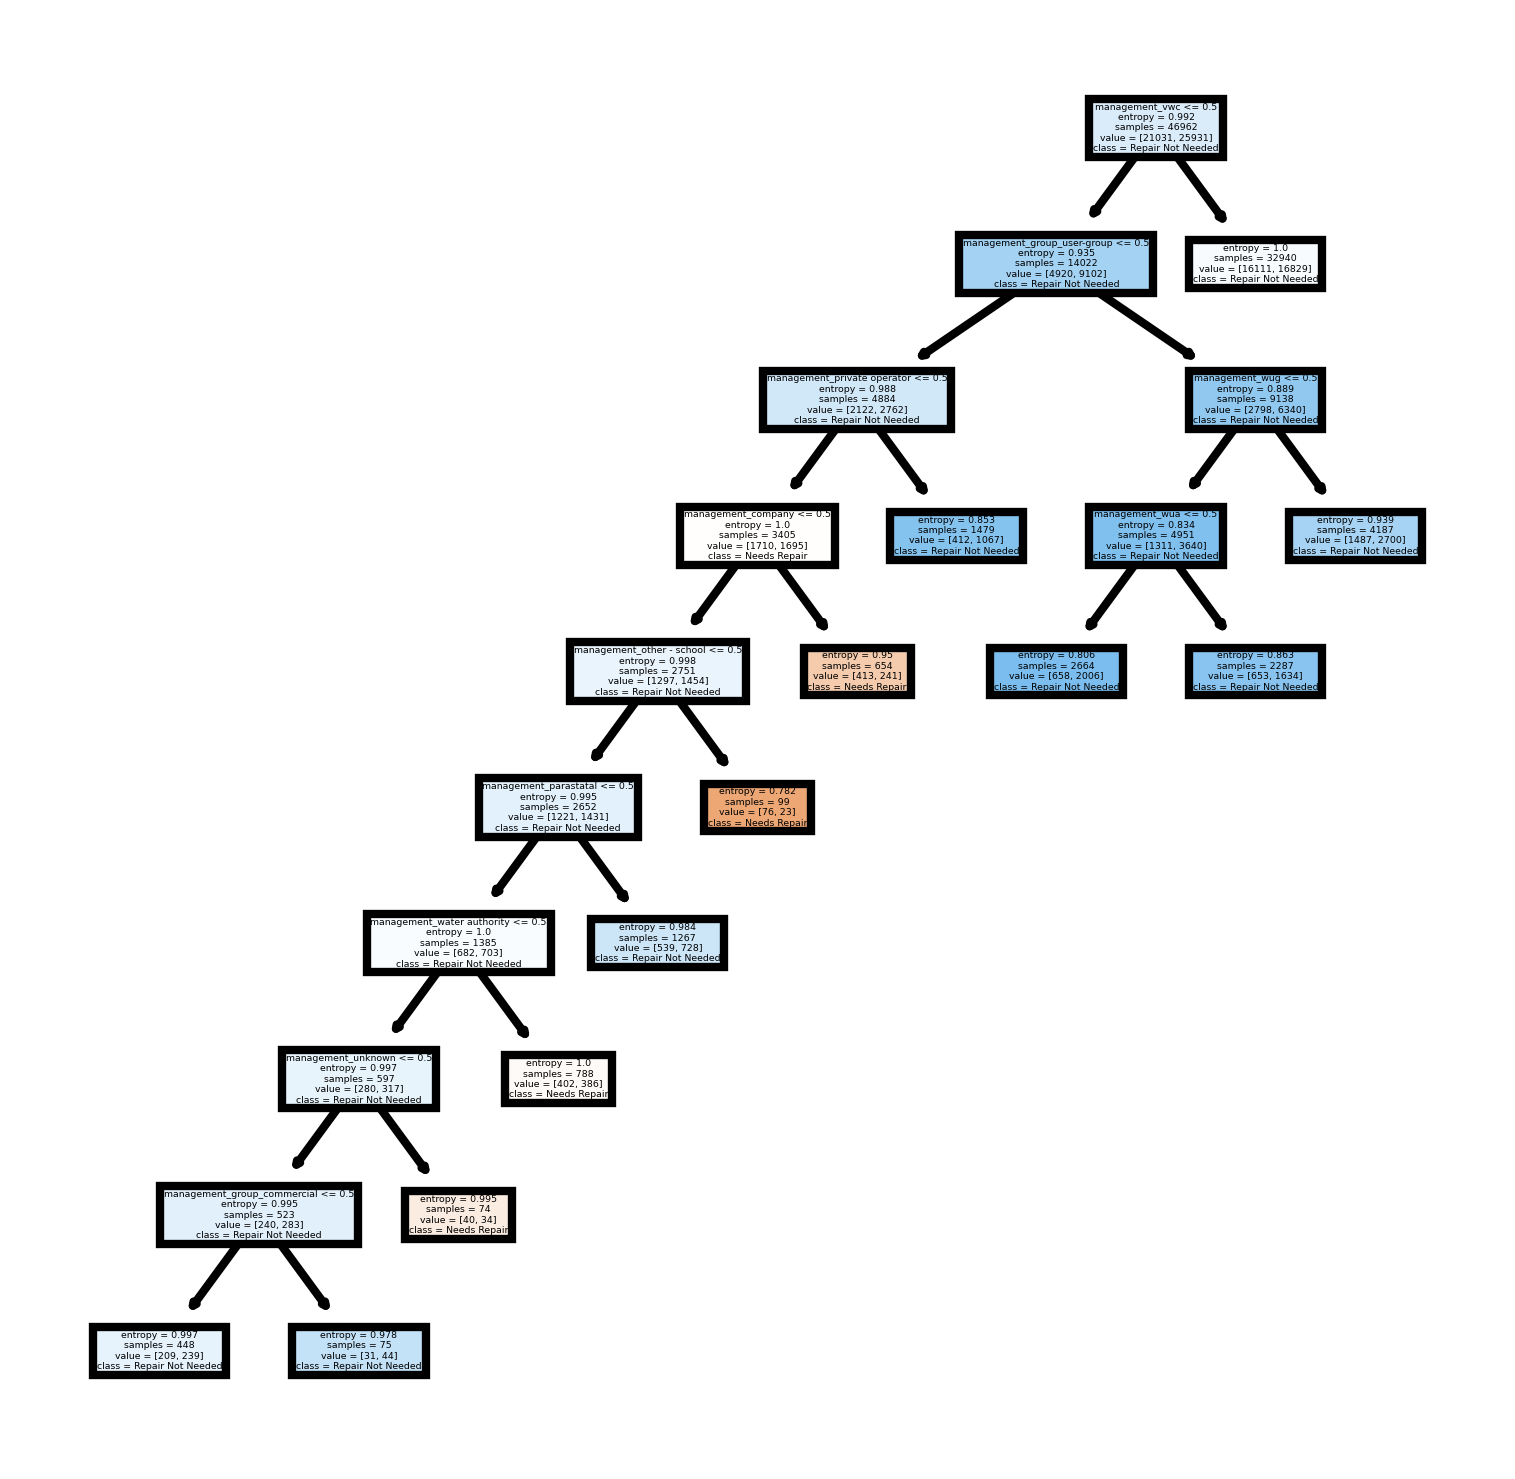

In [50]:
fig, axes = plt.subplots(nrows = 1,ncols = 1, figsize = (3,3), dpi=600)
tree.plot_tree(mgmt_tree, feature_names = ohe_df.columns, class_names = np.unique(y).astype('str'), filled = True)
plt.show()


## 4. Exploratory Data Analysis

## 4. <a name ="Modeling"></a>  Modeling

In [ ]:
# identifying predictor variables and target

y = data[['id','status_group']]
X = data.drop(columns = ['status_group'], axis = 1)

# initial 80/20 split into train and test sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.2)

#split test set into 80/20 split of test and validation data
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, random_state = 42, test_size = 0.2)

## 5. <a name ="Evaluation"></a> Evaluation

## 6. <a name ="Conclusions"></a> Conclusions

### Limitations

### Recommendations

### Next Steps

## 7. <a name ="Resources"></a> Resources

This project idea and data came from:

DrivenData. (2015). Pump it Up: Data Mining the Water Table. Retrieved [Month Day Year] from https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table.

Used this to create bold font in multiple_value_counts function in order to highlight the number of unique values in each feature to help with cardinality analysis of each feature
https://stackoverflow.com/questions/8924173/how-can-i-print-bold-text-in-python

Use this:

print '\033[1m' + 'Hello'

And to change back to normal:

print '\033[0m'

To create the map:
https://towardsdatascience.com/geopandas-101-plot-any-data-with-a-latitude-and-longitude-on-a-map-98e01944b972

To display all values in `.value_counts()`: https://stackoverflow.com/questions/68291502/expand-value-counts-view

used this during data understanding

For info on Tanzania water supply: https://www.globalwaters.org/sites/default/files/7dec_tanzania_institutional-frameworksforwatersupply.pdf